In [103]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [105]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [106]:
set_seed(cfg.seed)

In [107]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [108]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [109]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [110]:
print(base_prompt)

tensor([[ 338, 5059,  262, 6672,  287, 2669,   13, 9570, 5865, 3205]])


In [111]:
import random

rng = random.Random(cfg.seed)

In [112]:
rng.randint(0,100)

81

In [113]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


In [114]:
import operator
from teren.perturbations import SAEFeaturePerturbation, TestPerturbation, NaiveRandomPerturbation, SAEActivationPerturbation, SyntheticActivationPerturbation, OtherFeaturePerturbation
from teren.utils import get_random_activation

In [115]:
# Examining SAE features
def get_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, reduce=True):

    base_f_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: base_f_acts[feature_idx] for feature_idx in range(base_f_acts.shape[0]) if base_f_acts[feature_idx] / base_f_acts.max() > thresh}

    random_features = {feature_idx: base_f_acts[feature_idx] for feature_idx in random.sample(range(base_f_acts.shape[0]), 20) if base_f_acts[feature_idx] == 0}

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = base_f_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = base_f_acts[min_dot]
            print(min_dot)

    sorted_base_features = sorted(active_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    base_results = defaultdict(defaultdict)
    target_results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)

    for i in tqdm(range(n_control)):

        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        print(
            f"Base Recon Error: {(sae.decode(sae.encode(exp_ref.act)) - exp_ref.act).abs().sum()}"
        )
        print(
            f"Target Recon Error: {(sae.decode(sae.encode(target)) - target).abs().sum()}"
        )

        target_f_acts = sae.encode(target)[0, -1, :]
        target_features = {feature_idx: target_f_acts[feature_idx] for feature_idx in range(target_f_acts.shape[0]) if target_f_acts[feature_idx] / target_f_acts.max() > thresh}
        sorted_target_features = sorted(target_features.items(), key=operator.itemgetter(1))

        print(f"Using {len(target_features.keys())} target active features: {target_features}")
        
        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=reduce)
        control[i].append(control_kl_div)

        print(sae.encode(target).shape)
        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=reduce)
        sae_control[i].append(sae_kl_div)
        
        for i in range(len(sorted_base_features)):
            other_feature_perturbation = OtherFeaturePerturbation(exp_ref, sorted_base_features[i], target_f_acts[sorted_base_features[i][0]], dataset, sae)
            base_kl_div = run_perturbation(cfg, exp_ref, other_feature_perturbation, reduce=reduce)
            base_results[sorted_base_features[i][0]]['kl_div'] = base_kl_div

        for j in range(len(sorted_target_features)):
            other_feature_perturbation = OtherFeaturePerturbation(exp_ref, sorted_target_features[j], base_f_acts[sorted_target_features[j][0]], dataset, sae)
            target_kl_div = run_perturbation(cfg, exp_ref, other_feature_perturbation, reduce=reduce)
            target_results[sorted_target_features[j][0]]['kl_div'] = target_kl_div

        base_feature_activation = torch.Tensor([feature[1] for feature in sorted_base_features])
        for i, feature in enumerate(sorted_base_features):
            base_results[feature[0]]['Feature Activation'] = base_feature_activation[i]

        target_feature_activation = torch.Tensor([feature[1] for feature in sorted_target_features])
        for i, feature in enumerate(sorted_target_features):
            target_results[feature[0]]['Feature Activation'] = target_feature_activation[i]

    return base_results, target_results, control, sae_control


In [116]:
def plot_results(fig, ax, base_results, target_results, control, sae_control):

    i = 0
    for control_kl_div in control.values():
        ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

    for sae_kl_div in sae_control.values():
        ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
        ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    for f_idx in base_results.keys():
        print(base_results[f_idx]['kl_div'].min())
        ax[i][0].plot(base_results[f_idx]['kl_div'], color='green', linewidth=0.5)
        ax[i][1].plot(base_results[f_idx]['kl_div'], color='green', linewidth=0.5)
        ax[i][2].plot(np.log10(base_results[f_idx]['kl_div']), color='green', linewidth=0.5)

    for f_idx in target_results.keys():
        print(target_results[f_idx]['kl_div'].min())
        ax[i][0].plot(target_results[f_idx]['kl_div'], color='yellow', linewidth=0.5)
        ax[i][1].plot(target_results[f_idx]['kl_div'], color='yellow', linewidth=0.5)
        ax[i][2].plot(np.log10(target_results[f_idx]['kl_div']), color='yellow', linewidth=0.5)

    #ax.legend(fontsize=8)
    ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][0].set_ylabel("KL divergence to base logits")
    #ax[i][0].set_xlim(0, 361)
    #ax[i][0].set_ylim(-0.1, 20)

    ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][1].set_ylabel("KL divergence to base logits")
    #ax[i][1].set_xlim(0, 361)
    #ax[i][1].set_ylim(-0.1, 20)

    ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][2].set_ylabel("KL divergence to base logits")
    #ax[i][2].set_xlim(0, 180)
    #ax[i][2].set_ylim(-0.01, 2)
    

In [117]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 1
    base_results, target_results, controls, sae_controls = get_results_for_prompt(exp_ref, cfg, sae, n_control=n_control, thresh = 0.1, reduce=True)

    if i == 0:     
        all_base_results = base_results  
        all_target_results = target_results                             
        all_controls = controls
        all_sae_controls = sae_controls
    else:
        for f_idx, result in base_results.items():
            all_base_results[f_idx]['kl_div'] = result

        for f_idx, result in target_results.items():
            all_target_results[f_idx]['kl_div'] = result

        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[  938,  2121,    11,   607,   749,  1029,    12, 13317,  2720,   373]])
Prompt:  last fall, her most high-profile interview was
12757
Using 1 active features: {18988: tensor(23.2065)}


Base Recon Error: 136.50250244140625
Target Recon Error: 163.2508087158203
Using 4 target active features: {3626: tensor(4.4957), 18581: tensor(29.5895), 21958: tensor(5.3441), 24149: tensor(4.6475)}
torch.Size([1, 1, 24576])
Base Recon Error: 136.50250244140625
Target Recon Error: 163.2508087158203
23.20646858215332 0.0
4.495711803436279 0.0
4.647479057312012 1.2702698707580566
5.3440656661987305 1.0815298557281494
29.58952522277832 0.0


100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


tensor(4.7508e-08)
tensor(-1.2943e-06)
tensor(-8.5340e-07)
tensor(-9.6625e-07)
tensor(4.7508e-08)


/tmp/ipykernel_8023/4153882002.py:22: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(target_results[f_idx]['kl_div']), color='yellow', linewidth=0.5)


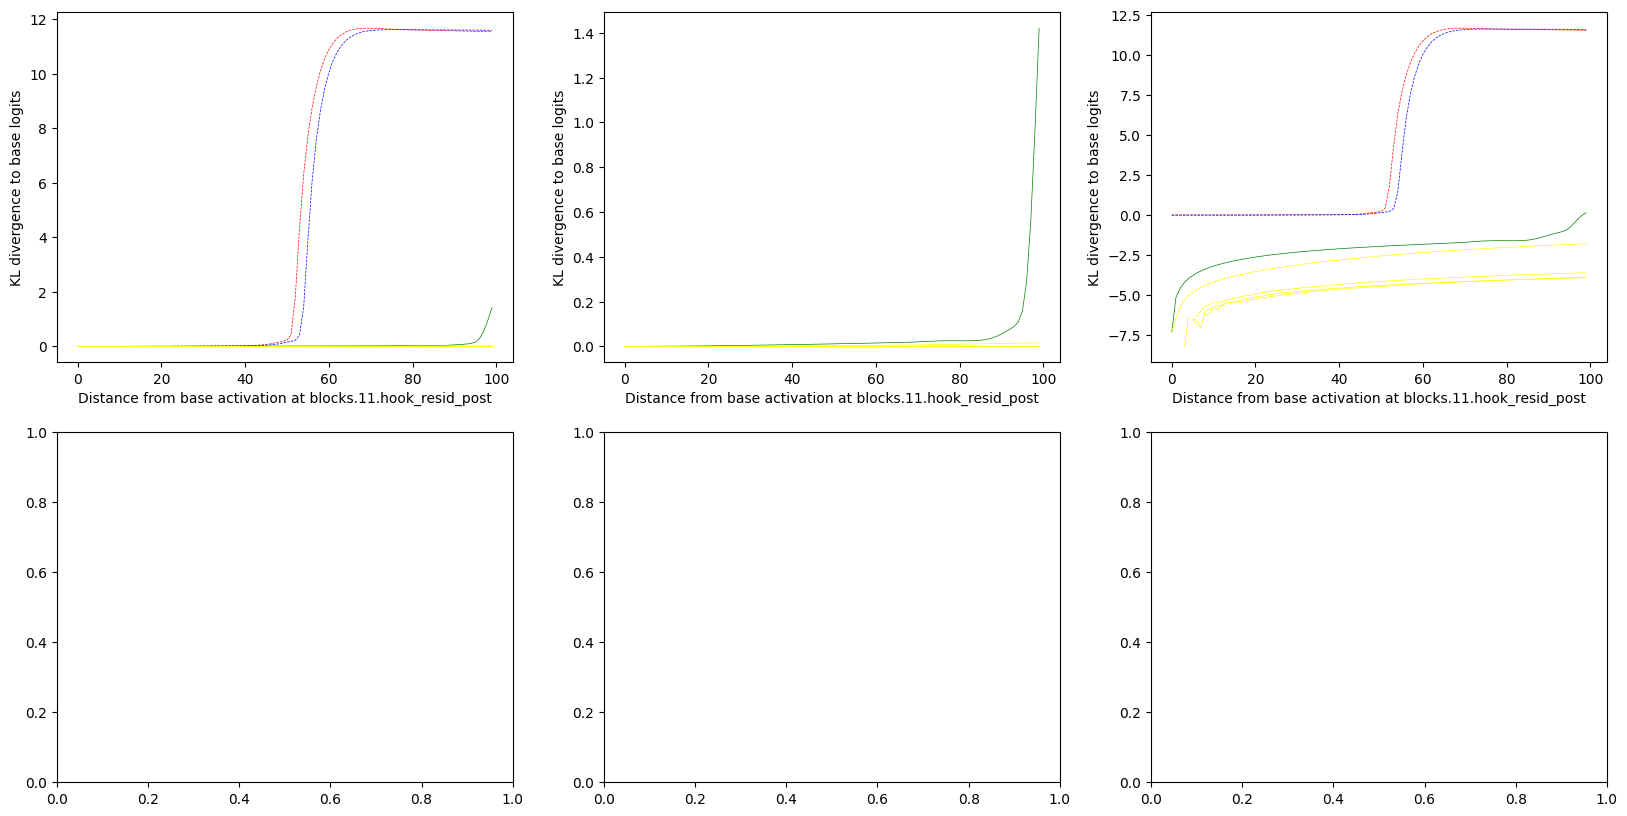

In [118]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

plot_results(fig, ax, all_base_results, all_target_results, all_controls, all_sae_controls)
fig.show()

In [ ]:
def plot_all_results(fig, ax, base_results, target_results, control, sae_control, properties):
    
    base_colors = plt.cm.viridis(np.linspace(0,1,len(base_results.keys())))
    target_colors = plt.cm.plasma(np.linspace(0,1,len(target_results.keys())))
    i = 0
    color_property = "Feature Activation"

    for control_kl_div in control.values():
        ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
        #ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

    for sae_kl_div in sae_control.values():
        ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
        #ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    base_plot_order = sorted(base_results.items(), key = lambda item: item[1][color_property])
    target_plot_order = sorted(target_results.items(), key = lambda item: item[1][color_property])

    for j, (feature_idx, data) in enumerate(base_plot_order):
        kl_div = data['kl_div']
        ax[i][0].plot(kl_div, color=base_colors[j], linewidth=0.5)
        ax[i][1].plot(kl_div, color=base_colors[j], linewidth=0.5)
        ax[i][2].plot(np.log10(kl_div), color=base_colors[j], linewidth=0.5)

    for j, (feature_idx, data) in enumerate(target_plot_order):
        kl_div = data['kl_div']
        ax[i][0].plot(kl_div, color=target_colors[j], linewidth=0.5)
        ax[i][1].plot(kl_div, color=target_colors[j], linewidth=0.5)
        ax[i][2].plot(np.log10(kl_div), color=target_colors[j], linewidth=0.5)

    #ax.legend(fontsize=8)
    ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][0].set_ylabel("KL divergence to base logits")
    #ax[i][0].set_xlim(0,361)
    #ax[i][0].set_ylim(-0.1, 20)

    ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][1].set_ylabel("KL divergence to base logits")
    #ax[i][1].set_xlim(0,361)
    #ax[i][1].set_ylim(-0.1, 20)

    ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
    ax[i][2].set_ylabel("KL divergence to base logits")
    #ax[i][2].set_xlim(0,75)
    #ax[i][2].set_ylim(-0.01,2)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=properties[color_property][0], vmax=properties[color_property][1]))
    cbar = fig.colorbar(sm, ax=ax[i][2])
    cbar.set_label(color_property)
    

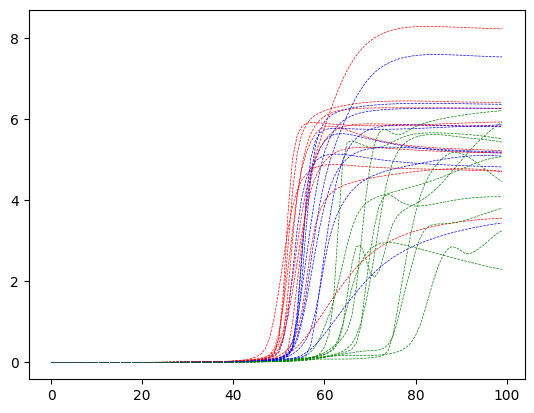

In [24]:
for i in range(n_control):
    plt.plot(all_controls[i][0], color='red', linestyle='--', linewidth=0.5)
    plt.plot(all_sae_controls[i][0], color='blue', linestyle='--', linewidth=0.5)
    plt.plot(all_syns[i][0], color='green', linestyle='--', linewidth=0.5)

In [189]:
syn_cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.0.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [190]:
saes, sparsities = get_gpt2_res_jb_saes(syn_cfg.perturbation_layer)
sae = saes[syn_cfg.perturbation_layer].cpu()
sparsity = sparsities[syn_cfg.perturbation_layer].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


In [191]:
# Examining SAE features
def get_syn_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, reduce=True):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    sorted_features = sorted(active_features.items(), key=operator.itemgetter(1))
    sorted_features2 = sorted(random_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    targets = []
    target_sims = []
    for i in range(200):
        if len(targets) == 1:
            break
        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        b_exp = exp_ref.act - sae.b_dec.unsqueeze(0).unsqueeze(0)
        t_exp = target - sae.b_dec.unsqueeze(0).unsqueeze(0)
        cos_sim = torch.einsum("... k, ... k -> ...", b_exp, t_exp) / (torch.norm(b_exp, dim=-1) * torch.norm(t_exp, dim=-1))
        '''
        if cos_sim > 0.0:
            continue
        '''
        targets.append(target)
        target_sims.append(cos_sim)

    results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)
    for i in tqdm(range(len(targets))):

        random_activation_perturbation = RandomActivationPerturbation(exp_ref, targets[i], dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=reduce)
        control[i].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, targets[i], dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=reduce)
        sae_control[i].append(sae_kl_div)

        random_add_perturbation = RandomActivationPerturbation(exp_ref, targets[i] - sae.b_dec.unsqueeze(0).unsqueeze(0), dataset, additive=True)
        kl_div = run_perturbation(cfg, exp_ref, random_add_perturbation, reduce=reduce, sae=sae)
        results[i]['kl_div'] = kl_div
        results[i]['cos_sim'] = target_sims[i]

    return control, sae_control, results

In [192]:
def plot_syn_results(fig, ax, control, sae_control, results):
    colors = plt.cm.viridis(np.linspace(0,1,len(results.keys())))

    for i in range(2):
        for control_kl_div in control.values():
            ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
            ax[i][2].plot(np.log10(control_kl_div[0]), color='red', label=f"Control", linewidth=0.5, linestyle="--")

        for sae_kl_div in sae_control.values():
            ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
            ax[i][2].plot(np.log10(sae_kl_div[0]), color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    plot_order = sorted(results.items(), key = lambda item: item[1]['cos_sim'])

    for j, (idx, data) in enumerate(plot_order):
        kl_div = data['kl_div']
        ax[0][0].plot(kl_div, color=colors[j], linewidth=0.5)
        ax[0][1].plot(kl_div, color=colors[j], linewidth=0.5)
        ax[0][2].plot(np.log10(kl_div), color=colors[j], linewidth=0.5)

    for i in range(2):
        #ax.legend(fontsize=8)
        ax[i][0].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
        ax[i][0].set_ylabel("KL divergence to base logits")
        #ax[i][0].set_xlim(0, 20)
        #ax[i][0].set_ylim(-0.1, 20)

        ax[i][1].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
        ax[i][1].set_ylabel("KL divergence to base logits")
        #ax[i][1].set_xlim(0, 361)
        #ax[i][1].set_ylim(-0.1, 20)

        ax[i][2].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
        ax[i][2].set_ylabel("log10(KL divergence) to base logits")
        #ax[i][2].set_xlim(0, 180)
        #ax[i][2].set_ylim(-0.01, 2)


        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min([results[i]['cos_sim'] for i in results.keys()]), vmax=max([results[i]['cos_sim'] for i in results.keys()])))
        cbar = fig.colorbar(sm, ax=ax[i][2])
        cbar.set_label('Cosine sim')
    

In [193]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = torch.tensor([[  607,   355,   262,  5141,   546,  4150,  3397, 13121,   351,  8523]])
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 5
    controls, sae_controls, results = get_syn_results_for_prompt(exp_ref, syn_cfg, sae, n_control=n_control, thresh = 0.05, reduce=False)

    if i == 0:                                    
        all_controls = controls
        all_sae_controls = sae_controls
        all_results = results
    else:
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control
        
        for control_idx, result in results.items():
            all_results[n_control*i+control_idx] = result

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 303,  587, 5597,  284,  670,  351, 1854, 1973,  262, 3096]])
Prompt: ve been prepared to work with others across the board
Using 6 active features: {7034: tensor(0.6255), 7550: tensor(0.6969), 13907: tensor(3.2155), 15603: tensor(0.6714), 18458: tensor(0.3439), 24182: tensor(0.2796)}


Base Recon Error: 79226.140625
Target Recon Error: 80463.59375


100%|██████████| 1/1 [00:04<00:00,  4.16s/it]

Initial feature activations: tensor([1.3864, 3.2865, 2.8366,  ..., 2.4764, 1.7459, 3.2568])
Final feature activations: tensor([5.9973, 7.6112, 4.9066,  ..., 0.0000, 2.2768, 7.6008])
Number of active features post pert: 7069


In [194]:
for i in all_results.keys():
    kl_div = all_results[i]['kl_div']
    print(kl_div[80], all_results[i]['cos_sim'])

tensor(0.1051) tensor([[0.5922]])


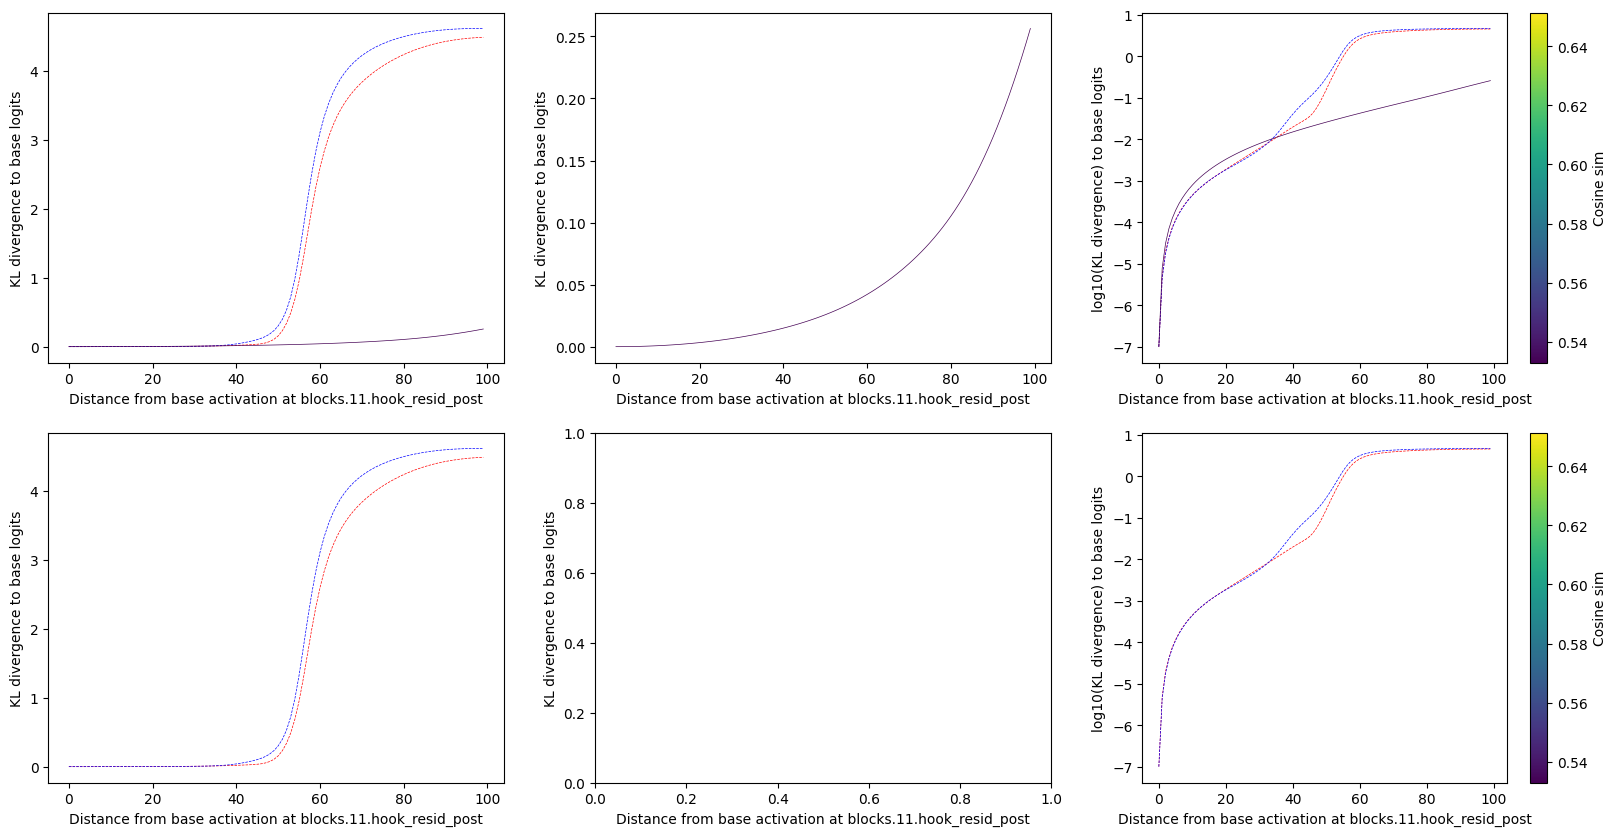

In [195]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_results)
fig.show()